In [1]:
"""環境"""
# .lab

"""更新履歴"""
# 最終更新日：2025/05/21
# 2025/05/21 shutilを使って、cachedirを洗浄することにしました
# 2025/05/15 simple_progress_barおよびdata(dict)を使い始めました。
# 2025/02/25 os.getcwd()を採用し、__file__を定義する必要をなくしました。

"""モジュール読み込み"""
# ファイル操作等
import sys
import os
# from datetime import datetime
from pprint import pprint
import logging
# import pickle
# import struct
from tqdm import tqdm
import h5py
# import threading
import json

# tkinter
from tkinter import filedialog, messagebox, Tk

# データ分析ツール
import pandas as pd
import numpy as np
import scipy as sp
# import math
# from sklearn.linear_model import LinearRegression

# グラフ等作成用
import matplotlib
import matplotlib.pyplot as plt         # 図の作成用
from PIL import Image as im
# import cv2
from IPython.display import display, HTML, clear_output, update_display, Image

# 自作モジュール
sys.path.append(r"C:\Users\okaza\pythonenv")
from modules.Mytools.Tools import print_fileinfo, h5_tree, dict_tree, simple_progress_bar, clean_cache_except_logfiles, get_total_size
import modules.Mytools.Settings
import modules.fitXRD as fx
from modules.peakfit import peakfit, pseudoVoigt

"""ログ管理ツール作成"""
# chche directoryの設定
cachedir = os.path.abspath(os.getcwd() + "/.cache")
clean_cache_except_logfiles(cachedir)
os.makedirs(cachedir, exist_ok=True)

# loggerの作成
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
format = "%(levelname)-9s  %(asctime)s [%(filename)s:%(lineno)d] %(message)s"

# Streamハンドラクラスを作成
sh = logging.StreamHandler()
sh.setLevel(logging.DEBUG)
sh.setFormatter(logging.Formatter(format))
logger.addHandler(sh)

# Fileハンドラクラスをインスタンス化
logfile = cachedir + ""
fh = logging.FileHandler(filename=cachedir + "/notebook.log", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter(format))
logger.addHandler(fh)
logger.debug("[Activate workspace]: " + os.getcwd())
logger.debug("[Set cache]: "+ os.path.abspath(cachedir))
logger.debug("[Activate log]: " + os.path.abspath(cachedir + "/notebook.log"))

# globalなデータを作成
data = dict()
logger.debug("[Create global variable]: data")

DEBUG      2025-05-21 17:36:40,418 [388102471.py:71] [Activate workspace]: c:\Users\okaza\pythonenv\lf\twocolor
DEBUG      2025-05-21 17:36:40,419 [388102471.py:72] [Set cache]: c:\Users\okaza\pythonenv\lf\twocolor\.cache
DEBUG      2025-05-21 17:36:40,420 [388102471.py:73] [Activate log]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\notebook.log
DEBUG      2025-05-21 17:36:40,420 [388102471.py:77] [Create global variable]: data


## 目的

2色法で温度を計算します。

## 1. 生データ読み込み

まず、SPEファイルを読み込みます

In [2]:
from modules.SpeReadPy.read_spe import SpeReference

In [ ]:
def read_spe():

    # spe生データ
    spefile = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-04\Okazaki\mDIH07\LF_1\mDIH07  04.spe"

    if True: # [ Main ]
        # データ読み込み
        spe = SpeReference(spefile)
        logger.info("[File]: " + os.path.abspath(spefile))

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["data"] = spe.get_data()[0]
        data[key]["wavelength"] = spe.get_wavelengths()[0]
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
read_spe()
del read_spe

INFO       2025-05-21 17:36:44,434 [2940950259.py:9] [File]: C:\Users\okaza\Box\DataStrorage\SPring8-2025-04\Okazaki\mDIH07\LF_1\mDIH07  04.spe
INFO       2025-05-21 17:36:44,806 [2940950259.py:16] [Add variables]: read_spe (data = 0.00 MB)



└── read_spe
    ├── data <class 'numpy.ndarray'> [shape = (175, 400, 1340)]
    └── wavelength <class 'numpy.ndarray'> [shape = (1340,)]

生データを確認します。

DEBUG      2025-05-21 17:36:50,532 [2211868408.py:41] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\display_rawdata.png
INFO       2025-05-21 17:36:50,533 [2211868408.py:51] [Add variables]: display_rawdata (data = 0.00 MB)


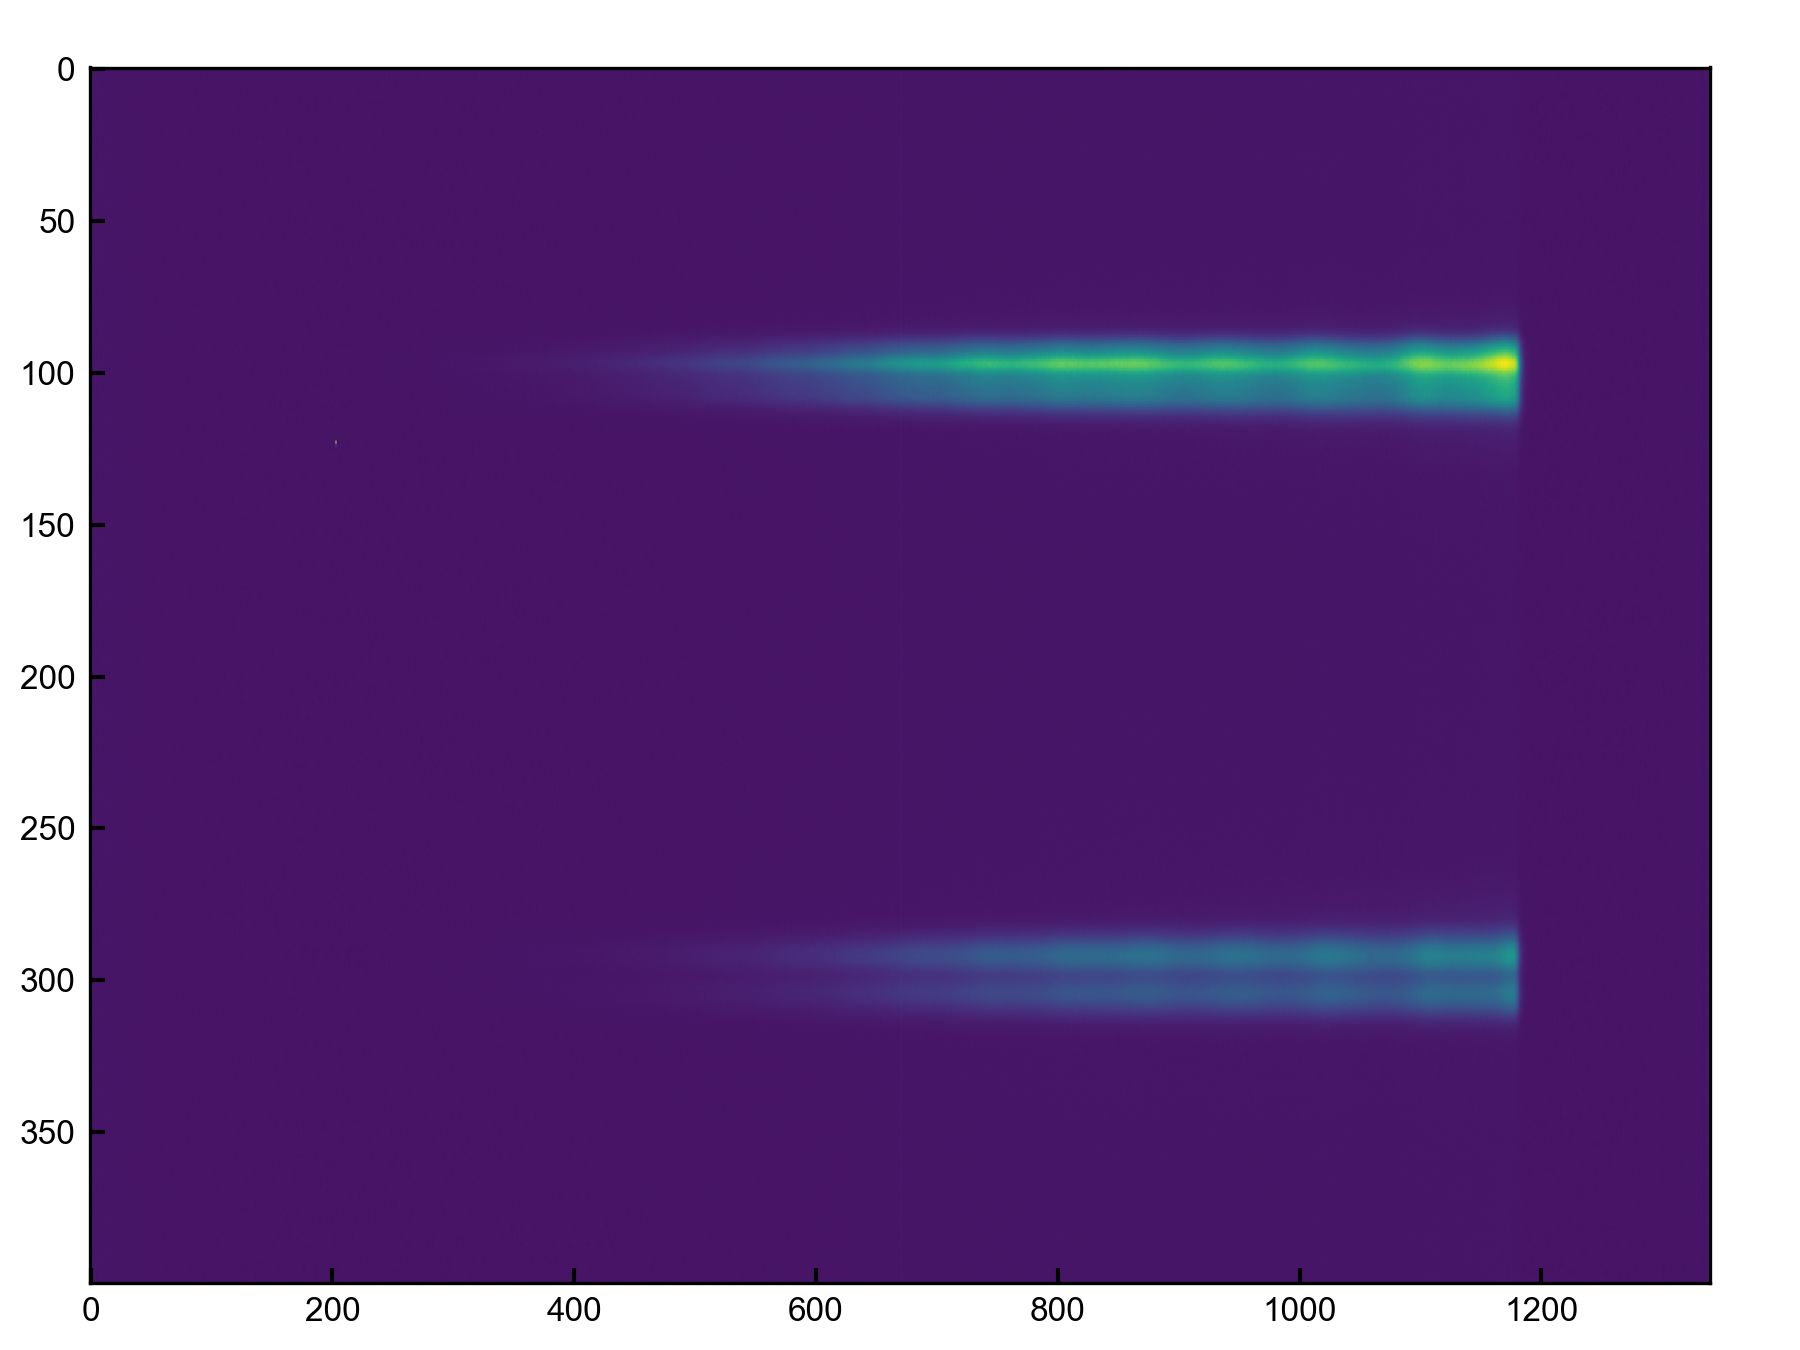


├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (175, 400, 1340)]
│   └── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
└── display_rawdata
    └── refframe <class 'int'>

In [ ]:
def display_rawdata():

    # フレーム
    refframe = 120

    if True: # [ Main ]

        # 例外処理
        if refframe < 0:
            refframe = 0
        elif refframe >= data["read_spe"]["data"].shape[0]:
            refframe = data["read_spe"]["data"].shape[0]-1

        # figの作成
        fig,ax = plt.subplots()
        fig.set_size_inches(6,4.5)
        fig.set_dpi(300)

        # imshow
        ax.imshow(
            data["read_spe"]["data"][refframe],
            aspect = "auto"
        )

        # axの調整
        fig.subplots_adjust(
            0.05,0.05,0.95,0.95,
        )

        # 画像の表示
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["refframe"] = refframe
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
display_rawdata()
del display_rawdata

## 2. 補正

続いて補正をかけます。

In [ ]:
def add_calib():

    # 校正データ
    spectrumdata = r"C:\Users\okaza\pythonenv\twocolors\ReferenceData\OL245C.csv"

    # フィルターデータ
    standard_up = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-05\CeO2\Tcalib_BLAZE_20250514\standard\0_Up_std.spe"
    standard_down = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-05\CeO2\Tcalib_BLAZE_20250514\standard\0-Down_std.spe"

    if True: # [ Main ]
        
        # 補正データの読み込み
        std_data = dict()
        std_data["OD"] = dict()
        std_data["OD"]["up"] = SpeReference(standard_up).get_data()[0][0]
        std_data["OD"]["down"] = SpeReference(standard_down).get_data()[0][0]
        std_data["spectrum"] = dict()
        std_data["spectrum"]["csvdata"] = pd.read_csv(spectrumdata).values.T
        logger.debug("[Load]: std_data")

        # スペクトルデータの補完
        spectrum_interp = sp.interpolate.interp1d(
            *std_data["spectrum"]["csvdata"],
            kind = "cubic"
        )
        std_data["spectrum"]["interp"] = spectrum_interp(data["read_spe"]["wavelength"])
        logger.debug("[Calc]: Interpolation of spectrum data")

        # 補正
        calibrated = dict()
        calibrated["wavelength"] = data["read_spe"]["wavelength"]
        calibrated["data"] = (
            data["read_spe"]["data"]
            * np.stack(
                [np.vstack(
                    [std_data["spectrum"]["interp"]]*data["read_spe"]["data"].shape[1]
                )]*data["read_spe"]["data"].shape[0],
                axis = 0
            )
            / np.stack(
                [np.vstack(
                    [std_data["OD"]["up"]]*(data["read_spe"]["data"].shape[1]//2)
                    + [std_data["OD"]["down"]]*(data["read_spe"]["data"].shape[1]//2)
                )]*data["read_spe"]["data"].shape[0],
                axis = 0
            )
        )
        logger.debug("[Calc]: Correction")

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["calibrated"] = calibrated
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
add_calib()
del add_calib

DEBUG      2025-05-21 17:36:53,677 [70096032.py:19] [Load]: std_data
DEBUG      2025-05-21 17:36:56,163 [70096032.py:27] [Calc]: Interpolation of spectrum data
DEBUG      2025-05-21 17:36:56,962 [70096032.py:48] [Calc]: Correction
INFO       2025-05-21 17:36:56,963 [70096032.py:54] [Add variables]: add_calib (data = 0.00 MB)



├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (175, 400, 1340)]
│   └── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
├── display_rawdata
│   └── refframe <class 'int'>
└── add_calib
    └── calibrated
        ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
        └── data <class 'numpy.ndarray'> [shape = (175, 400, 1340)]

補正データの可視化を行います。

DEBUG      2025-05-21 17:36:59,539 [3413444968.py:33] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\display_calibrated.png


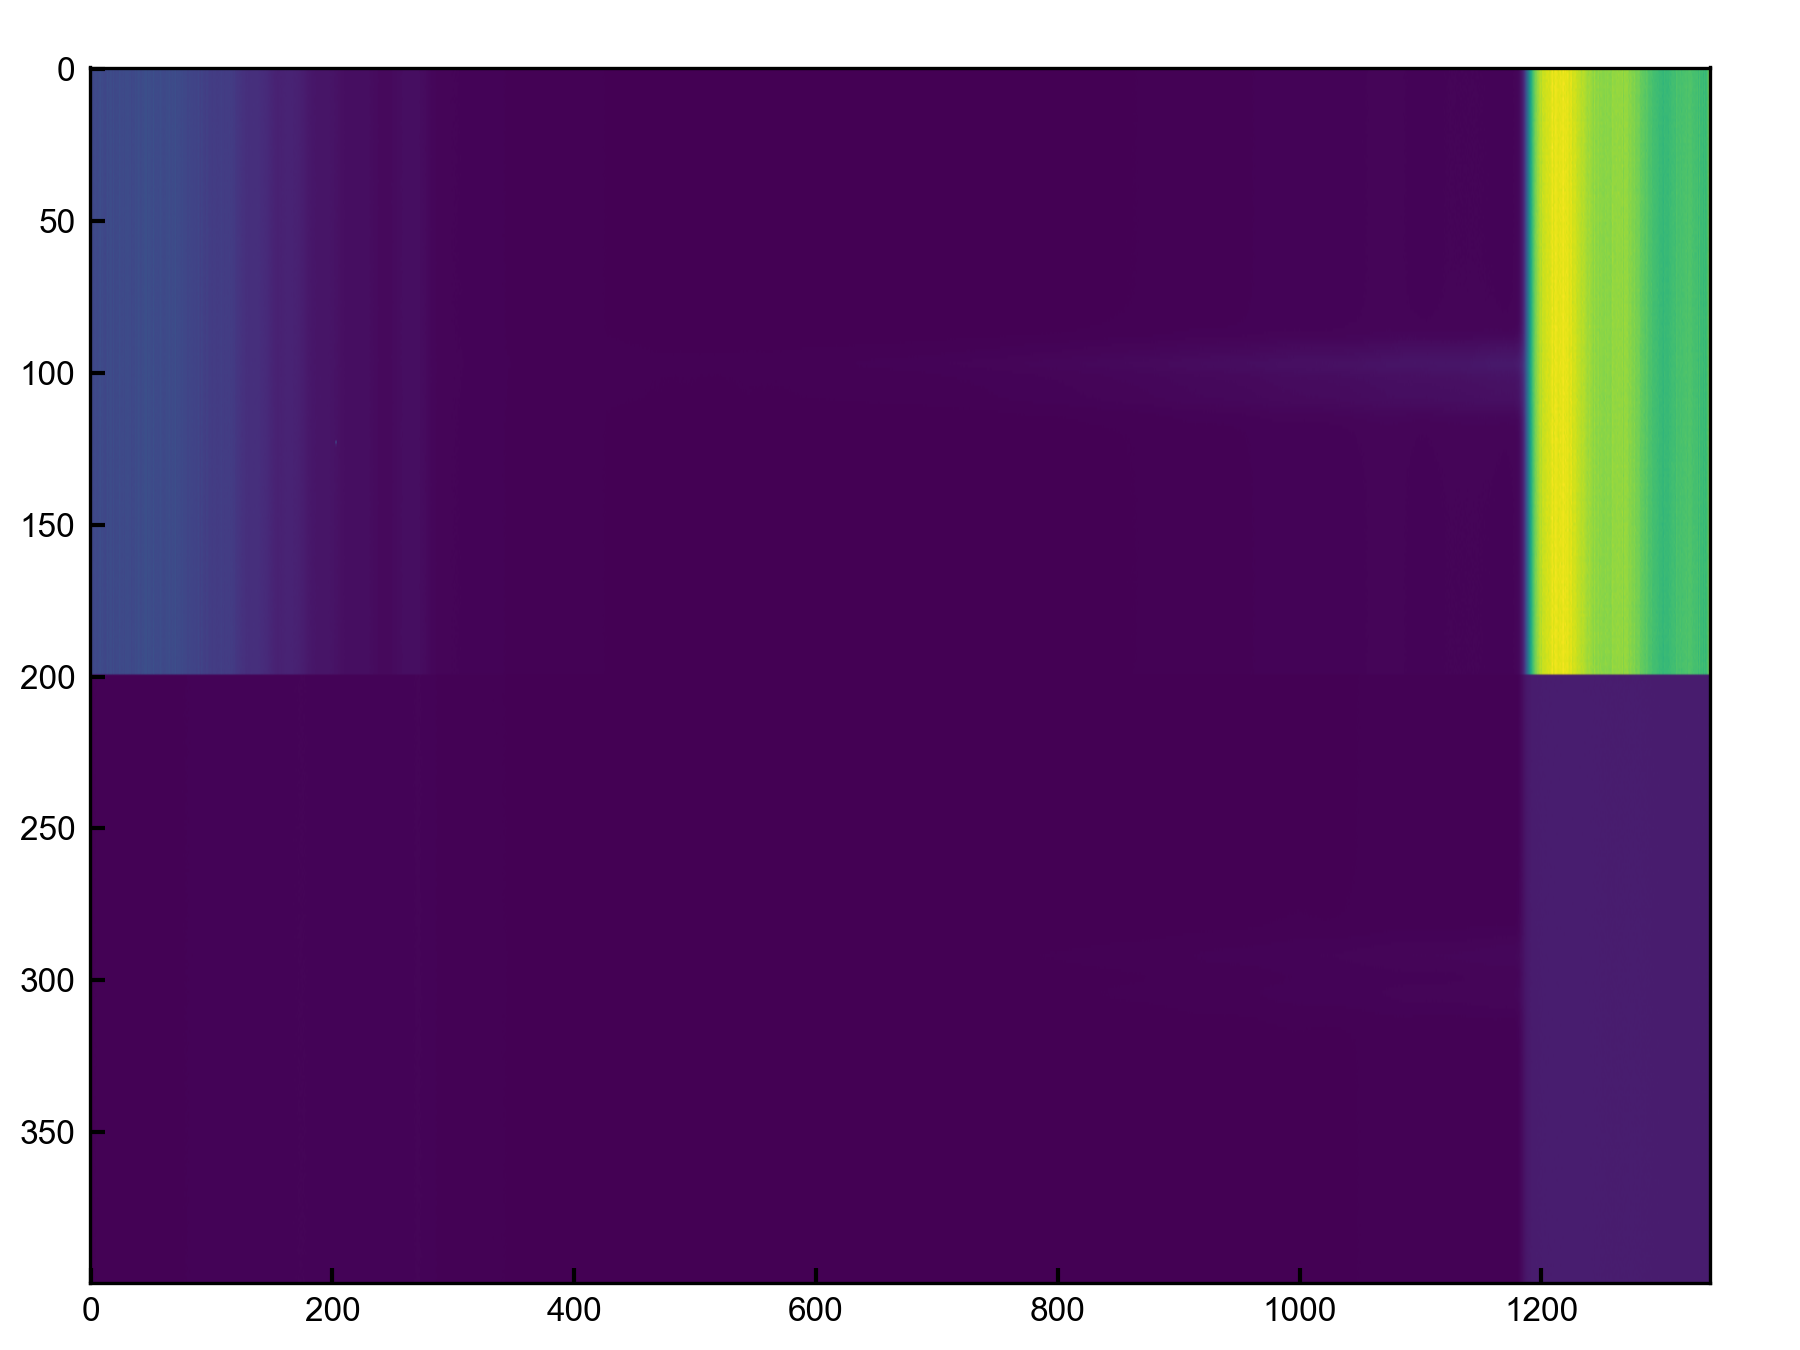

In [6]:
def display_calibrated():

    # 変数読み出し
    image = data["add_calib"]["calibrated"]["data"]
    refframe = data["display_rawdata"]["refframe"]

    # fig作成
    fig,ax = plt.subplots()
    fig.set_size_inches(6,4.5)
    fig.set_dpi(300)

    # imshow
    ax.imshow(
        image[refframe],
        aspect = "auto"
    )

    fig.subplots_adjust(
        0.05,0.05,0.95,0.95,
    )

    # 画像の表示
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    key = sys._getframe().f_code.co_name
    imgfilename = cachedir + "/{}.png".format(key)
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
    # pdffilename = cachedir + "/{}.pdf".format(key)
    # plt.savefig(pdffilename)
    # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
    plt.close()
    display(Image(filename = imgfilename, width = 600))
                
    return
display_calibrated()
del display_calibrated

## 3. 計算範囲の指定

試しに温度計算を行います。

DEBUG      2025-05-21 17:37:04,158 [2793270739.py:58] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\set_wavelength.png


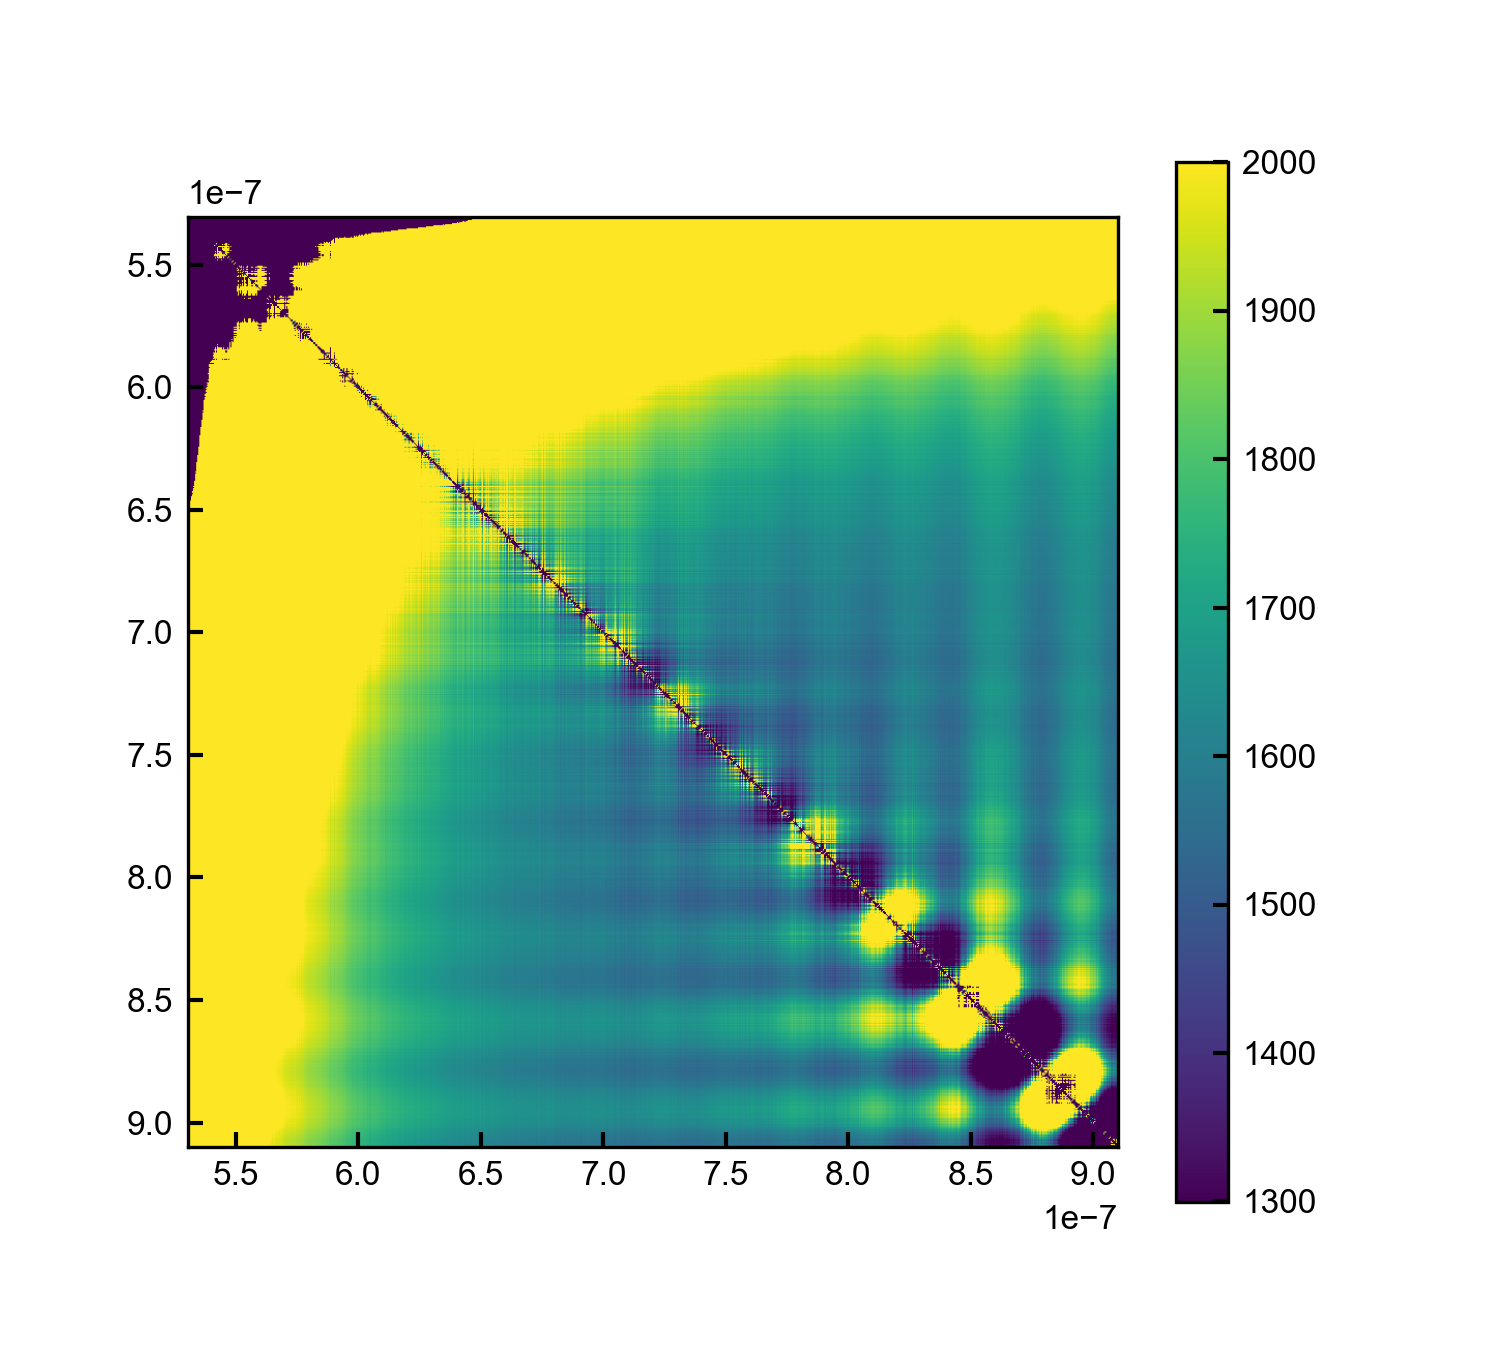

In [7]:
def set_wavelength():

    frame = 90
    pix = 91

    wrange = (530, 910)
    trange = (1300, 2000)

    if True: # Main

        # 変数読込
        w = (data["add_calib"]["calibrated"]["wavelength"]*1e-9)
        i = (data["add_calib"]["calibrated"]["data"][frame, pix])
        index = np.arange(i.shape[0])

        # 統合データ作成
        constant = 1e9 # nm -> m
        dataframe = np.vstack([index, w, i]).T[(w>wrange[0]/constant) * (w<wrange[1]/constant)].T

        # マスク処理
        mask = ~np.tril(np.ones([dataframe.shape[1]]*2)).astype(np.bool_)
        nonzeromask = np.prod(np.stack(np.meshgrid(*([(dataframe[2] > 0)]*2)), axis = -1), axis = -1).astype(np.bool_)
        mask *= nonzeromask

        # 温度計算
        # 波長
        wset = np.stack(np.meshgrid(*([dataframe[1]]*2)), axis = -1)[mask].T
        lnW = np.log(wset[0]/wset[1])
        invW = (np.reciprocal(wset[0]) - np.reciprocal(wset[1]))
        # 強度
        iset = np.stack(np.meshgrid(*([dataframe[2]]*2)), axis = -1)[mask].T
        lnR = np.log(iset[0]/iset[1])
        # 温度
        temperature = -sp.constants.h*sp.constants.c/sp.constants.Boltzmann * invW / (lnR + 5 * lnW)

        # 計算した温度を成形する
        base = np.zeros([dataframe.shape[1]]*2)
        base[mask] = temperature
        base = base.T
        base[mask] = temperature

        # figを作成・表示
        fig, ax = plt.subplots()
        fig.set_size_inches((5,4.5))
        fig.set_dpi(300)
        cmap = ax.imshow(base,vmax = trange[1], vmin = trange[0], extent = (dataframe[1][0], dataframe[1][-1], dataframe[1][-1], dataframe[1][0]), aspect="equal")
        fig.colorbar(mappable=cmap)
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()
        display(Image(filename = imgfilename, width = 500))

    return
set_wavelength()
del set_wavelength

計算する波長範囲を指定します。

INFO       2025-05-21 17:37:44,960 [3042079472.py:19] [Add variables]: range
DEBUG      2025-05-21 17:37:45,283 [3042079472.py:81] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\select_ranges.png
INFO       2025-05-21 17:37:45,284 [3042079472.py:90] [Add variablse]: select_ranges (data = 1431.29 MB)


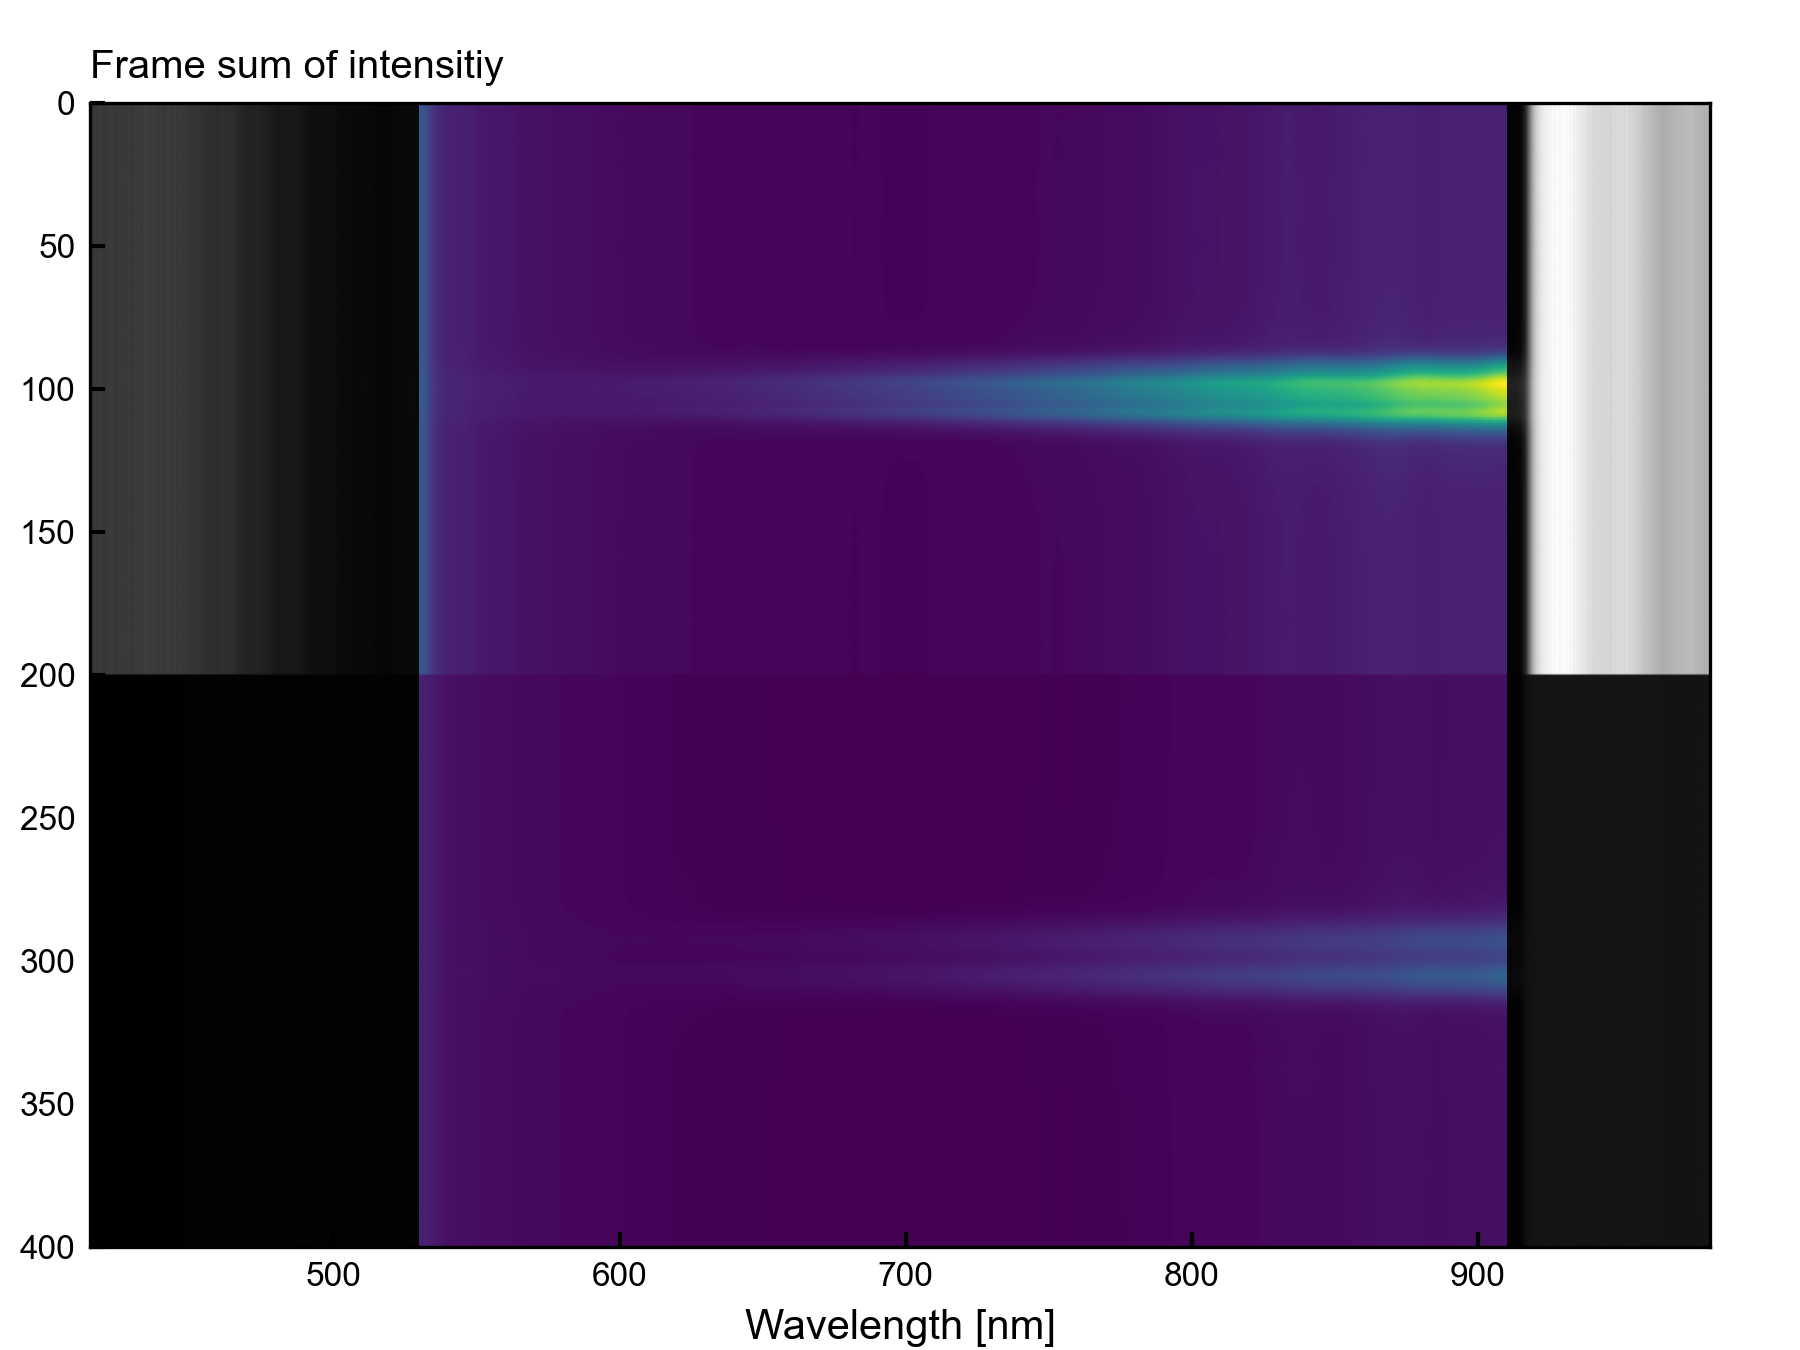


├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (175, 400, 1340)]
│   └── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
├── display_rawdata
│   └── refframe <class 'int'>
├── add_calib
│   └── calibrated
│       ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│       └── data <class 'numpy.ndarray'> [shape = (175, 400, 1340)]
└── select_ranges
    └── wavelength_range <class 'tuple'>

In [10]:
def select_ranges():
    
    # 波長範囲
    wrange = (530, 910)

    if True: # [ Main ]

        # フラッグ処理
        flags = dict()
        ranges = dict()
        try:
            wrange # type: ignore
        except:
            wrange = None
            flags["w"] = False
        else:
            flags["w"] = True
            ranges["w"] = wrange
            logger.info("[Add variables]: range")

        # マスク作成
        mask = dict()
        sumdata = np.sum(data["add_calib"]["calibrated"]["data"], axis = 0)
        if flags["w"]:
            mask["w"] = (
                data["add_calib"]["calibrated"]["wavelength"] >= wrange[0] # type: ignore
            ) * (
                data["add_calib"]["calibrated"]["wavelength"] < wrange[-1] # type: ignore
            )

        # fig保存
        fig = plt.figure()
        fig.set_size_inches(6,4.5)
        fig.set_dpi(300)

        # ax作成
        axs = []
        axs.append(fig.add_axes(rect = (0.05,0.05,0.9,0.9)))
        axs[0].set_xlabel("Wavelength [nm]", fontsize = 10)
        axs[0].set_xlim(
            data["add_calib"]["calibrated"]["wavelength"][0],
            data["add_calib"]["calibrated"]["wavelength"][-1]
        )
        axs[0].set_ylim(len(sumdata),0)
        axs[0].set_title("Frame sum of intensitiy", loc = "left")

        # imshow
        axs[0].imshow(
            sumdata,
            extent = (
                data["add_calib"]["calibrated"]["wavelength"][0],
                data["add_calib"]["calibrated"]["wavelength"][-1],
                len(sumdata),
                0
            ),
            cmap = "grey"
        )
        if flags["w"]:
            axs[0].imshow(
                sumdata.T[mask["w"]].T,
                extent = (
                    wrange[0], # type: ignore
                    wrange[-1], # type: ignore
                    len(sumdata),
                    0
                ),
                cmap = "viridis"
            )

        # グラフ保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # データ格納
        data[key] = dict()
        data[key]["wavelength_range"] = wrange
        logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
select_ranges()
del select_ranges

計算するピクセル範囲を指定し、有効なデータ群を作成します。

DEBUG      2025-05-21 18:45:15,827 [113339497.py:83] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\select_pixranges.png
INFO       2025-05-21 18:45:15,830 [113339497.py:93] [Add variablse]: select_pixranges (data = 1431.29 MB)


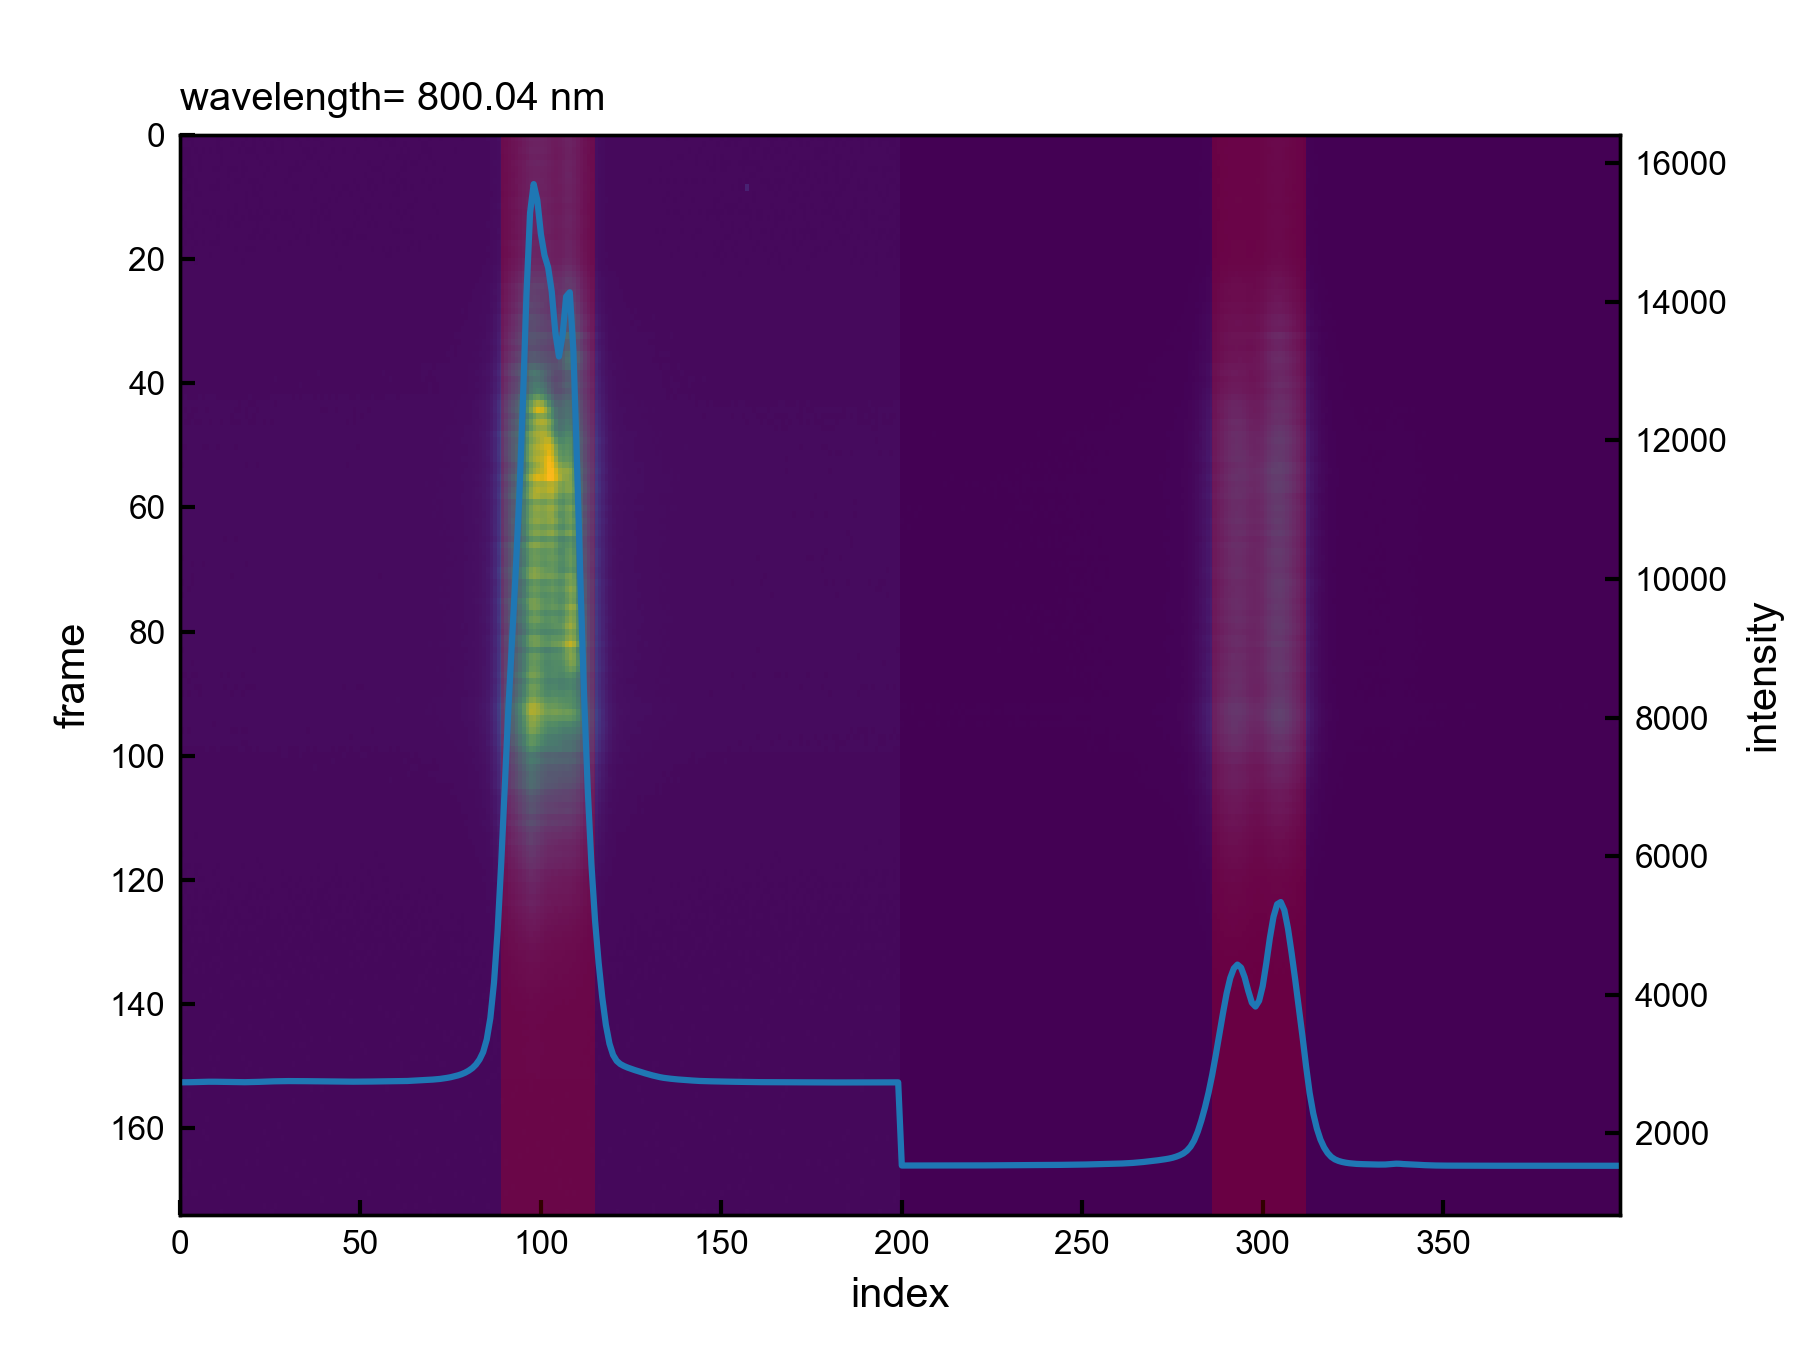


├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (175, 400, 1340)]
│   └── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
├── display_rawdata
│   └── refframe <class 'int'>
├── add_calib
│   └── calibrated
│       ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│       └── data <class 'numpy.ndarray'> [shape = (175, 400, 1340)]
├── select_ranges
│   └── wavelength_range <class 'tuple'>
└── select_pixranges
    ├── data <class 'numpy.ndarray'> [shape = (175, 52, 899)]
    └── wavelength <class 'numpy.ndarray'> [shape = (899,)]

In [40]:
def select_pixranges():

    # pix ranges
    xrange = ((89, 115), (286, 312))

    if True: # Main

        # 参照する波長
        ref_wavelength = 800 # nm

        # 強度の合計データ
        sumdata = np.sum(data["add_calib"]["calibrated"]["data"], axis = 0)

        # データ読込
        wavelength = data["add_calib"]["calibrated"]["wavelength"]

        # wavelength mask
        wavelength_mask = (
            wavelength >= data["select_ranges"]["wavelength_range"][0] # type: ignore
        ) * (
            wavelength < data["select_ranges"]["wavelength_range"][1] # type: ignore
        )

        # pix mask
        pix_mask = np.sum([
            (np.arange(len(sumdata)) >= xrange[i][0]) * (np.arange(len(sumdata)) < xrange[i][-1]) for i in range(2)
        ], axis = 0).astype(np.bool_)

        # データの作成
        validdata = dict()
        validdata["data"] = data["add_calib"]["calibrated"]["data"].transpose(2,0,1)[wavelength_mask].transpose(2,0,1)[pix_mask].transpose(2,0,1)
        validdata["wavelength"] = data["add_calib"]["calibrated"]["wavelength"][wavelength_mask]

        # figure作成
        fig = plt.figure()
        fig.set_size_inches(6,4.5)
        fig.set_dpi(300)

        # ax作成
        axs = []
        axs.append(fig.add_axes(rect = (0.1,0.1,0.8,0.8)))
        axs.append(axs[0].twinx())
        axs[0].set_xlabel("index", fontsize = 10)
        axs[0].set_ylabel("frame", fontsize = 10)
        axs[1].set_ylabel("intensity", fontsize = 10)
        axs[0].set_title("wavelength= {:.2f} nm".format(wavelength[(wavelength > ref_wavelength)][0]), loc = "left")

        image = data["add_calib"]["calibrated"]["data"].transpose(2,0,1)[wavelength >= ref_wavelength][0]
        axs[0].set_xlim(0,len(sumdata)-1)
        axs[0].set_ylim(image.shape[0]-1,0)

        axs[0].imshow(
            image,
            extent = (0, image.shape[1]-1,image.shape[0]-1, 0),
            aspect = "auto"
        )
        axs[1].plot(
            np.arange(len(sumdata)),
            np.sum(sumdata.T[wavelength_mask], axis = 0)
        )
        axs[1].set_ylim(axs[1].get_ylim())

        for i in range(2):
            axs[1].fill_betweenx(
                axs[1].get_ylim(),
                xrange[i][0],
                xrange[i][-1],
                fc = "red",
                alpha = 0.2,
            )

        # グラフ保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # データ格納
        data[key] = dict()
        data[key]["pix_range"] = xrange
        data[key] = validdata
        logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
select_pixranges()
del select_pixranges

## 4. 温度計算の実施

In [ ]:
import threading
import concurrent.futures as confu

2色法を実装します。

In [ ]:
def twocolors():

    # データ長の計測
    n_frame = validdata["data"].shape[0]
    n_cell = validdata["data"].shape[1]
    n_process = n_frame * n_cell
    logger.debug("Measure data lengths")
    logger.info("length of frame: {}".format(n_frame))
    logger.info("length of cell: {}".format(n_cell))

    # 波長の計算
    w = validdata["wavelength"]
    mask = ~np.tril(np.ones([w.shape[0]]*2)).astype(np.bool_)
    wset = np.stack(np.meshgrid(*([w]*2)), axis = -1)[mask].T
    lnW = np.log(wset[0]/wset[1])
    invW = (np.reciprocal(wset[0]) - np.reciprocal(wset[1]))
    logger.debug("Calculate values from wavelength data")

    # 出力格納用変数の定義
    hdffilename = cachedir + "/tempraw.hdf"

    # ファイルテンプレート作成（最初に1回だけ）
    with h5py.File(hdffilename, mode="w") as f:
        for i_frame in range(n_frame):
            g = f.create_group("frame = {}".format(i_frame))
            for i_cell in range(n_cell):
                g.create_dataset(
                    name = "cell = {}".format(i_cell),
                    shape = lnW.shape,  # 温度リストサイズ
                    dtype = np.float64
                )
    logger.debug("Template file created: " + os.path.abspath(hdffilename))
    print_fileinfo(hdffilename)

    # lock
    lock = threading.Lock()

    # 関数の定義
    def process(i_process):
        
        # データの抽出
        i_frame = i_process // n_cell
        i_cell = i_process % n_cell
        i = validdata["data"][i_frame, i_cell]

        # 強度の計算
        nonzeromask = np.prod(np.stack(np.meshgrid(*([(i > 0)]*2)), axis = -1), axis = -1)[mask].astype(np.bool_)
        iset = np.stack(np.meshgrid(*([i]*2)), axis = -1)[mask][nonzeromask].T
        lnR = np.log(iset[0]/iset[1])

        # 温度を算出
        constant = 1e9 # nm -> m
        temperature = -sp.constants.h*sp.constants.c/sp.constants.Boltzmann*constant * invW[nonzeromask] / (lnR + 5 * lnW[nonzeromask])
        
        # 出力
        base = np.zeros(lnW.shape)
        base[nonzeromask] = temperature
        return i_process, base
    logger.debug("Define the function")

    if True: # 
        # 演算
        with confu.ThreadPoolExecutor(max_workers=os.cpu_count()) as tpe:
            
            # 演算開始
            futures = [tpe.submit(process, i_process) for i_process in range(n_process)]

            # 終わったプロセスから順に出力
            for i, future in enumerate(confu.as_completed(futures)):
                i_process, temp = future.result()
                i_frame = i_process // n_cell
                i_cell = i_process % n_cell
                with lock:
                    with h5py.File(hdffilename, mode = "r+") as f:
                        f["frame = {}".format(i_frame)]["cell = {}".format(i_cell)][:] = temp
                simple_progress_bar(i+1, n_process)
                
    return
twocolors()
del twocolors

結果を可視化します

In [ ]:
import matplotlib.animation as anim

In [ ]:
def anim_imshow():

    trange = (1000, 2500) # 温度範囲
    cell = 13 # セル番号（入力しなかった場合は平均値が出力されます）
    wavelength_window = ((600, 650), (800, 900))

    if True: # imshow
        # w = validdata["wavelength"]
        # mask = ~np.tril(np.ones([w.shape[0]]*2)).astype(np.bool_)
        # base = np.zeros([w.shape[0]]*2)
        try:
            wavelength_window
        except:
            wavelength_window = None

        fig, ax = plt.subplots()

        hdffile = cachedir + "/tempraw.hdf"
        with h5py.File(hdffile, mode = "r") as f:
            n_frame = len(f.keys())
            # n_cell = len(f["frame = 0"].keys())
        return

        ims = []
        for i in (range(n_frame)):
            new = base.copy()
            with h5py.File(hdffile, mode = "r") as f:
                val = []
                for j in f["frame = {}".format(i)].keys():
                    val.append(f["frame = {}".format(i)][j][()])
            try:
                cell
            except:
                val = np.mean(np.stack(val, axis = 0), axis = 0)
            else:
                val = val[cell]
            new[mask] = val
            new = new.T
            new[mask] = val
            extent = (w[0], w[-1], w[-1], w[0])
                
            cmap = ax.imshow(
                new,
                vmax = trange[1],
                vmin = trange[0],
                extent = extent,
                alpha = 1 if (wavelength_window == None) else 0.5
            )

            tex = ax.text(0,1.01,"frame number = {:>4}".format(i),fontsize = 12, transform = ax.transAxes)
            ims.append([cmap, tex])
            simple_progress_bar(i+1, n_frame)

        plt.colorbar(mappable=cmap).set_label("Temperature [K]", fontsize = 10)
        ax.set_xlabel("Wavelength [m]")
        ax.set_ylabel("Wavelength [m]")

        #. Save
        logger.debug("[Save]: Animation")
        ani = anim.ArtistAnimation(fig, ims, interval = 300)
        filename = cachedir + "/anim_imshow.mp4"
        ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
        logger.info("[Save]: " + os.path.abspath(filename))

        plt.close()
    
    return
anim_imshow()
del anim_imshow

### 5. 計算結果の集計

ヒストグラムを作成します。

In [ ]:
def calc_hist():

    histrange = (1000, 2500) # ヒストグラムの作成レンジ
    num_bin = 201 # ヒストグラムの数

    if True: # [ Main ]

        if True: # flag
            try:
                cell
                flag_cell = True
            except:
                cell = None
                flag_cell = False

            global param_hist
            param_hist = dict()
            param_hist["range"] = histrange
            param_hist["num"] = num_bin
            logger.info("[Add variables]: param_hist")

        if True: # count
            t = value["temperature"]
            bins = np.linspace(*histrange, num_bin)

            n_calc = t.shape[0] * t.shape[1]
            i_calc = 0

            histogram = []
            for i in range(t.shape[0]):
                hists = []
                for j in range(t.shape[1]):
                    hist, _ = np.histogram(t[i, j], bins = bins)
                    hists.append(hist)
                    i_calc+=1
                    simple_progress_bar(i_calc, n_calc)
                hists = np.vstack(hists)
                histogram.append(hists)
            histogram = np.stack(histogram, axis = 0)
                
            value["histogram"] = dict()
            value["histogram"]["bins"] = bins
            value["histogram"]["hist"] = histogram
            logger.info("[Update]: value") 


    return
calc_hist()
del calc_hist

横軸ピクセル、縦軸温度です。

In [ ]:
def histmap():

    fig, ax = plt.subplots()
    # ax.set_xlim(0, spedata["data"].shape[1])
    ax.set_ylim(value["histogram"]["bins"][0], value["histogram"]["bins"][-1])
    ax.set_ylabel("Temperature [K]", fontsize = 10)

    n_frame = value["histogram"]["hist"].shape[0]
    ims = []
    for i_frame in range(n_frame):
        im = ax.imshow(
            value["histogram"]["hist"][i_frame].T,
            extent = (0, value["histogram"]["hist"].shape[1], value["histogram"]["bins"][-1], value["histogram"]["bins"][0]),
            aspect = "auto"
        )
        tex = ax.text(0,1.01,"frame number = {:>4}".format(i_frame),fontsize = 12, transform = ax.transAxes)
        ims.append([im, tex])
        simple_progress_bar(i_frame+1, n_frame)

    #. Save
    logger.debug("[Save]: Animation")
    ani = anim.ArtistAnimation(fig, ims, interval = 100)
    filename = cachedir + "/histmap.mp4"
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))

    plt.close()

    return
histmap()
del histmap

### 6. 試料温度の計算

試料位置を特定します。

In [ ]:
def detect_sample():

    framenumber = 131
    pixrange = ((17,21), (40,44))

    if True:

        fig, ax = plt.subplots()
        fig.set_size_inches(6,4.5)
        fig.set_dpi(120)

        ax.set_ylim(value["histogram"]["bins"][0], value["histogram"]["bins"][-1])
        ax.set_ylabel("Temperature [K]", fontsize = 10)
        ax.imshow(
            value["histogram"]["hist"][framenumber].T,
            extent = (0, value["histogram"]["hist"].shape[1], value["histogram"]["bins"][-1], value["histogram"]["bins"][0]),
            aspect = "auto"
        )
        ax.text(0,1.01,"frame number = {:>4}".format(framenumber),fontsize = 12, transform = ax.transAxes)
        for p in pixrange:
            ax.fill_betweenx(
                y = ax.get_ylim(),
                x1 = [p[0]]*2,
                x2 = [p[1]]*2,
                fc = "tab:red",
                alpha = 0.3
            )

        value["histogram"]["valid"] = (np.vstack([value["histogram"]["hist"].transpose(1,0,2)[p[0]:p[1]] for p in pixrange])).transpose(1,0,2)
        logger.info("[Update]: value")

        plt.show()
        plt.close()

    return
detect_sample()
del detect_sample

試料温度付近の温度変化を示します。

In [ ]:
def plot_res():

    if True: # [ Main ]

        if True: # plot
            fig, ax = plt.subplots()
            fig.set_size_inches(6,4.5)
            fig.set_dpi(120)

            ax.set_xlabel("Frame", fontsize = 10)
            ax.set_ylabel("Temperature [K]", fontsize = 10)

            hist2d = np.sum(value["histogram"]["valid"], axis = 1).T
            ax.imshow(
                hist2d,
                extent = (0,hist2d.shape[1], value["histogram"]["bins"][0], value["histogram"]["bins"][-1]),
                origin="lower",
                aspect = "auto"
            )
            plt.show()
            plt.close()

    return
plot_res()
del plot_res

### 7. フィッティング

フィッティングを行うフレームを決めます。

In [ ]:
def def_threshold():

    _threshold = 0.983

    if True:
        global threshold
        threshold = _threshold


        hoge = np.sum(np.sum(value["histogram"]["valid"], axis = 1), axis = 1) / (value["temperature"].shape[2] * value["histogram"]["valid"].shape[1])
        
        fig, ax = plt.subplots()
        fig.set_size_inches(6,4.5)
        fig.set_dpi(120)

        ax.plot(
            np.arange(hoge.shape[0]),
            hoge,
            lw = 0,
            marker = ".",
            ms = 3,
            c = "0"
        )
        ax.set_xlim(ax.get_xlim())
        ax.plot(
            ax.get_xlim(),
            [threshold]*2,
            c = "tab:orange"
        )
        plt.show()
        plt.close()

    return
def_threshold()
del def_threshold

結果をpseudo-Voigt関数でフィッティングします。

In [ ]:
from modules.peakfit import peakfit, pseudoVoigt

In [ ]:
def fit():

    # 演算データの選択
    data = value["histogram"]["valid"].transpose(1,0,2)

    # 出力格納用変数を定義
    global res
    res = [0]*data.shape[0]
    for i in range(data.shape[0]):
        res[i] = dict()
        res[i]["popt"] = [0]*data.shape[1]
        res[i]["pcov"] = [0]*data.shape[1]
        res[i]["r2"] = [0]*data.shape[1]

    # フィッティングを行う範囲を自動的に算出
    mask = np.sum(np.sum(value["histogram"]["valid"], axis = 1), axis = 1).astype(np.float64)
    mask /= (value["temperature"].shape[2] * value["histogram"]["valid"].shape[1])
    mask = np.vstack([(mask > threshold)]*data.shape[0]).T.astype(np.bool_).reshape(-1)
    
    # フィット用関数を定義
    pf = peakfit()
    reftemp = (value["histogram"]["bins"][:-1] + value["histogram"]["bins"][1:])/2
    def process(i):
        i_pix = i % data.shape[0]
        i_frame = i // data.shape[0]
        res = pf.fit_Vigot_func(theta = reftemp, intensity = data[i_pix, i_frame].astype(np.float64))
        return i, res
    
    # マルチスレッドを使いながら演算
    n_fit = data.shape[0] * data.shape[1]
    with confu.ThreadPoolExecutor() as tpe:
        futures = [tpe.submit(process, i_fit) for i_fit in np.arange(n_fit)[mask]]
        for i, future in enumerate(confu.as_completed(futures)):
            i_fit, val = future.result()
            i_pix = i_fit % data.shape[0]
            i_frame = i_fit // data.shape[0]
            res[i_pix]["popt"][i_frame] = val[0]
            res[i_pix]["pcov"][i_frame] = val[1]
            res[i_pix]["r2"][i_frame] = val[2]
            simple_progress_bar(i+1, np.sum(mask))
    logger.info("[Add variables]: res")

    return
fit()
del fit

フィッティング結果を表示します。

In [ ]:
def anime_fitres():

    # データの整理
    data = value["histogram"]["valid"].transpose(1,0,2)
    reftemp = (value["histogram"]["bins"][:-1] + value["histogram"]["bins"][1:])/2

    # フィッティング曲線を描くフレームを抽出
    validmask = ~np.array([(type(l) == int) for l in res[0]["popt"]])
    
    # figureの定義
    fig, ax = plt.subplots()
    ax.set_xlim(value["histogram"]["bins"][0], value["histogram"]["bins"][-1])
    ax.set_xlabel("Temperature [K]", fontsize = 10)
    ax.set_ylabel("Count", fontsize = 10)

    # グラフ要素描写
    n_pix = data.shape[0]
    n_frame = data.shape[1]
    ims = []
    for i_frame in range(n_frame):
        im = ax.plot(
            reftemp,
            np.sum(data, axis = 0)[i_frame],
            lw = 0,
            c = "0",
            marker = ".",
            ms = 2
        )[0]
        fit = []
        vals = []
        if validmask[i_frame]:
            for i_pix in range(n_pix):
                val = pseudoVoigt(reftemp, *res[i_pix]["popt"][i_frame])
                fit.append(ax.plot(
                    reftemp,
                    val,
                    lw = 1
                )[0])
                vals.append(val)
            fit.append(ax.plot(
                reftemp,
                np.sum(np.vstack(vals), axis = 0),
                c = "0",
                lw = 1
            )[0])
        else:
            fit.append(ax.plot(
                reftemp,
                [300.]*reftemp.shape[0],
                c = "0",
                lw = 1
            )[0])
        tex = ax.text(0,1.01,"frame number = {:>4}".format(i_frame),fontsize = 12, transform = ax.transAxes)
        ims.append([im, *fit, tex])
        simple_progress_bar(i_frame+1, n_frame)

    # 保存
    logger.debug("[Save]: Animation")
    ani = anim.ArtistAnimation(fig, ims, interval = 300)
    filename = cachedir + "/anime_fitres.mp4"
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))
    plt.close()

    return
anime_fitres()
del anime_fitres

In [ ]:
def fit_res():

    # マスクの作成
    validmask = ~np.array([(type(l) == int) for l in res[0]["popt"]])

    global csvdata
    csvdata = []

    for frame in range(len(res[0]["popt"])):
        if validmask[frame]:
            temp = np.array([res[i_pix]["popt"][frame][3] for i_pix in range(len(res))])
            val = np.mean(temp)
            std = np.std(temp, ddof = 1)
            err1 = np.mean([np.mean([res[i_pix]["popt"][frame][4:6]])/4 for i_pix in range(len(res))])
            err = np.sqrt(np.square(std) + np.square(err1))
            csvdata.append([
                frame,
                val,
                err
            ])
        else:
            csvdata.append([frame,
                         300,
                         0
                         ])
    csvdata = np.array(csvdata).T

    if True:
        fig, ax = plt.subplots()
        fig.set_size_inches(6,4.5)
        fig.set_dpi(120)

        ax.set_xlabel("Frame", fontsize = 10)
        ax.set_ylabel("Temperature [K]", fontsize = 10)

        hist2d = np.sum(value["histogram"]["valid"], axis = 1).T
        ax.imshow(
            hist2d,
            extent = (0,hist2d.shape[1], value["histogram"]["bins"][0], value["histogram"]["bins"][-1]),
            origin="lower",
            aspect = "auto"
        )
        ax.set_xlim(ax.get_xlim())
        ax.set_ylim(ax.get_ylim())
        ax.errorbar(
            csvdata[0],
            csvdata[1],
            yerr = csvdata[2],
            c = "tab:orange",
            alpha = 0.7,
            marker = ".",
            lw = 0,
            mew = 0,
            ms = 6,
            elinewidth=1
        )
        
        plt.show()
        plt.close()

    return
fit_res()
del fit_res

温度データをcsvで保存します

In [ ]:
def save_csv():

    csvfile = cachedir + "/output.csv"
    data = pd.DataFrame(csvdata.T)
    data.columns = ["Frame", "Temperature [K]", "Error [K]"]
    
    data.to_csv(csvfile, index=None)
    logger.info("[Save]: "+ os.path.abspath(csvfile))
    display(data)

    return
save_csv()
del save_csv